## Correlation to attractiveness rating, solely on the face to body.

Started off using a basic regression model to find a semblence of a pattern - there clearly is.

However, since this model is trained on purely CFs, it doesn't work well for the other races hence it's best to use a sequential ensemble for race then to the appropriate regression model.

examples of misses on bodytype are below. Since it's trained on CFs it hits races which stray from it very hard. 

e.g.

1527366134_Talisha_0

todos
-----
- beef up the regression model.
- run on AFs

In [1]:
from PIL import Image
import hdbscan
import time
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from umap import UMAP
from image_helpers import *
from tsne import image_scatter_plot
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context("poster")
%pylab inline

import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [5]:
data, paths, encodings, arrays_rescaled, X = load_encodings('../data/CF_ALL_faces_encodings.pickle')


In [4]:
_, paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = load_encodings('../data/tinder_pics_likes_faces_deduped_firsts_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_2017_deduped_firsts_faces_encodings.pickle')
paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder = append_new_dataset(paths_tinder, encodings_tinder, arrays_rescaled_tinder, X_tinder, '../data/tinder_pics_dislikes_faces_firsts_deduped_encodings.pickle')


356 356 356 356
994 994 994 994


In [24]:
from sklearn.linear_model import LogisticRegression, LinearRegression

In [15]:
df_ratings = pd.read_csv('../data/SCUT-FBP5500_v2/train_test_files/All_labels.txt', sep=' ', header=None)
df_ratings.columns = ['file_name', 'mean_rating']

In [18]:
look_up_file_to_attractiveness_rating = dict(zip(df_ratings['file_name'], df_ratings['mean_rating']))
paths = [file_path.replace('_face', '').split('/')[-1] for file_path in paths]
colors_dic = [look_up_file_to_attractiveness_rating.get(just_file_name) for just_file_name in paths]
pd.Series(colors_dic).value_counts()

df_file_ratings=pd.DataFrame()
df_file_ratings['ratings']=colors_dic 
df_file_ratings['file_names']=paths 


In [22]:
CF_ALL_labels = df_file_ratings['ratings']

In [30]:
def get_rsquared(y, x):
    '''
    Get RMSE given response variable (y) and predictor set (X)
    USE CASE: helper function for VIF
    '''
    import statsmodels.api as sm

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
 
    return model.rsquared

get_rsquared(CF_ALL_labels, encodings)

0.7795699505323137

In [31]:
def model_cv_score(model, feat_matrix, labels, folds=10, scoring='r2'):
    from sklearn import cross_validation
    '''
    I: persisted model object, feature matrix (numpy or pandas datafram), labels, k-folds, scoring metric
    O: mean of scores over each k-fold (float)
    '''
    return cross_validation.cross_val_score(model, feat_matrix, labels, cv=folds, scoring=scoring)

model_cv_score(LinearRegression(), encodings, CF_ALL_labels)


array([0.54761599, 0.66559548, 0.68838434, 0.72599725, 0.67858874,
       0.67199966, 0.73026636, 0.71951485, 0.6052623 , 0.65551991])

In [35]:
from sklearn.ensemble import RandomForestRegressor

model_cv_score(RandomForestRegressor(n_estimators=500, n_jobs=-1), encodings, CF_ALL_labels)

array([0.35473437, 0.54688793, 0.62844515, 0.58719008, 0.51766672,
       0.53656515, 0.61803058, 0.56824219, 0.46899944, 0.52149958])

In [38]:
lr = LinearRegression().fit(encodings, CF_ALL_labels)

In [45]:
preds_tinder = lr.predict(encodings_tinder)

In [55]:
num_of_dislikes = len(paths_tinder) - 356

In [56]:
tinder_labels = np.r_[np.ones(356), np.zeros(num_of_dislikes) ]

In [91]:
paths_tinder_ = [path.split('/')[-1].replace('_face.png','').replace('_face.jpg','') for path in paths_tinder]

In [92]:
df = pd.DataFrame (list(zip(paths_tinder_, preds_tinder, tinder_labels)))
df.columns = ['file_name', 'rating', 'like_or_not']
df

,file_name,rating,like_or_not
0,1527363788_Anoushka_0,3.380884,1.0
1,1527366134_Talisha_0,1.293723,1.0
2,1526522411_Bria_1,3.189360,1.0
3,1527365707_Rose_0,4.050745,1.0
4,1525746651_Athena_1,3.152286,1.0
5,1526004657_Samanta_0,3.294915,1.0
6,1527365210_Ayse_0,2.674185,1.0
7,1525746599_Alex_1,3.480318,1.0
8,1526593996_Angelica_0,3.797686,1.0
9,1526837215_Keanu_0,3.756583,1.0


In [94]:
df[df.rating > 4.3 ]

,file_name,rating,like_or_not
55,1526093265_Stephanie_0,4.591325,1.0
75,1526265289_Alexa_0,4.438037,1.0
80,1526093218_Soha_0,4.334965,1.0
92,1526093389_Brianna_1,4.380263,1.0
129,1490837468_Katie_5,4.342177,1.0
328,1488416347_Martyna_1,4.387710,1.0
346,1489201378_Bára_1,4.736726,1.0
655,1526346764_Elena_0,4.452377,0.0
664,1527365913_Özlem_0,4.374512,0.0
813,1527364877_Katie_0,4.354571,0.0


In [99]:
df[(df.rating > 4.0)  & (df.like_or_not == 0.0)]

,file_name,rating,like_or_not
388,1526003029_Ali_0,4.137162,0.0
429,1526609933_Sarah_0,4.019497,0.0
488,1526346830_Geetanjali_3,4.113359,0.0
513,1526004699_Bianca_0,4.077647,0.0
574,1526609939_Irina_0,4.158713,0.0
623,1526593772_Andrea_0,4.094030,0.0
655,1526346764_Elena_0,4.452377,0.0
664,1527365913_Özlem_0,4.374512,0.0
721,1526610012_Amanda_2,4.005788,0.0
730,1527364104_Lauren_0,4.007808,0.0


It clearly doesn't work well with africans. I'd have to made a classifier which would lead to a regressors for submodels to CF, AF, africans, etc.

In [103]:
df[(df.rating < 2.6)  & (df.like_or_not == 1.0)]

,file_name,rating,like_or_not
1,1527366134_Talisha_0,1.293723,1.0
26,1526837526_Ruth_2,2.253480,1.0
49,1526003957_Katie_0,2.485055,1.0
122,1490752195_Shoko_1,2.550221,1.0
131,1490751364_Darkgirl_1,2.560297,1.0
156,1490751366_Sarah_1,1.912751,1.0
234,1487300741_Linette_0_negative,2.253532,1.0
251,1490835717_Misty_0,2.481683,1.0
289,1490404659_Laura_1,2.574259,1.0
290,1489452972_Michelle_1,2.520080,1.0


In [93]:
df[df.rating < 1.5 ]

,file_name,rating,like_or_not
1,1527366134_Talisha_0,1.293723,1.0
379,1527364726_Shinekwa_0,1.387490,0.0
555,1526003771_Brittni_0,1.086195,0.0
621,1526836885_Adesuwa_0,1.352503,0.0
632,1526265620_Maryline_0,1.190813,0.0
735,1526004698_Peri_1,1.029219,0.0
889,1526003326_Samantha_2,1.458907,0.0


In [71]:
df[df.like_or_not == 1.0].rating.median()

3.4408789137863103

My likes clearly contain higher rated people but I expected a larger distinction. As it stands it's about 0.5. Could be a product of the classifier I'm using ( Linear Regression )

count    994.000000
mean       3.203834
std        0.540309
min        1.029219
25%        2.869386
50%        3.242769
75%        3.558196
max        4.736726
Name: rating, dtype: float64
skew --  -0.5440480942636227
kurtosis -- 0.7305612585468739


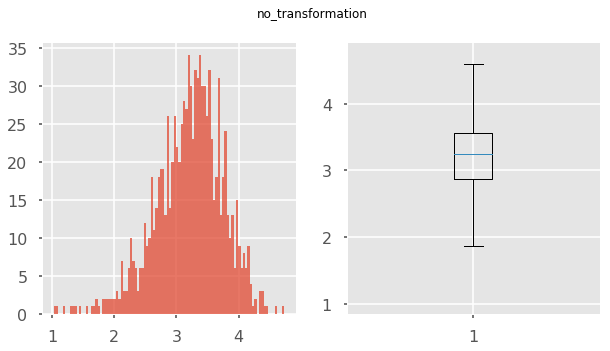

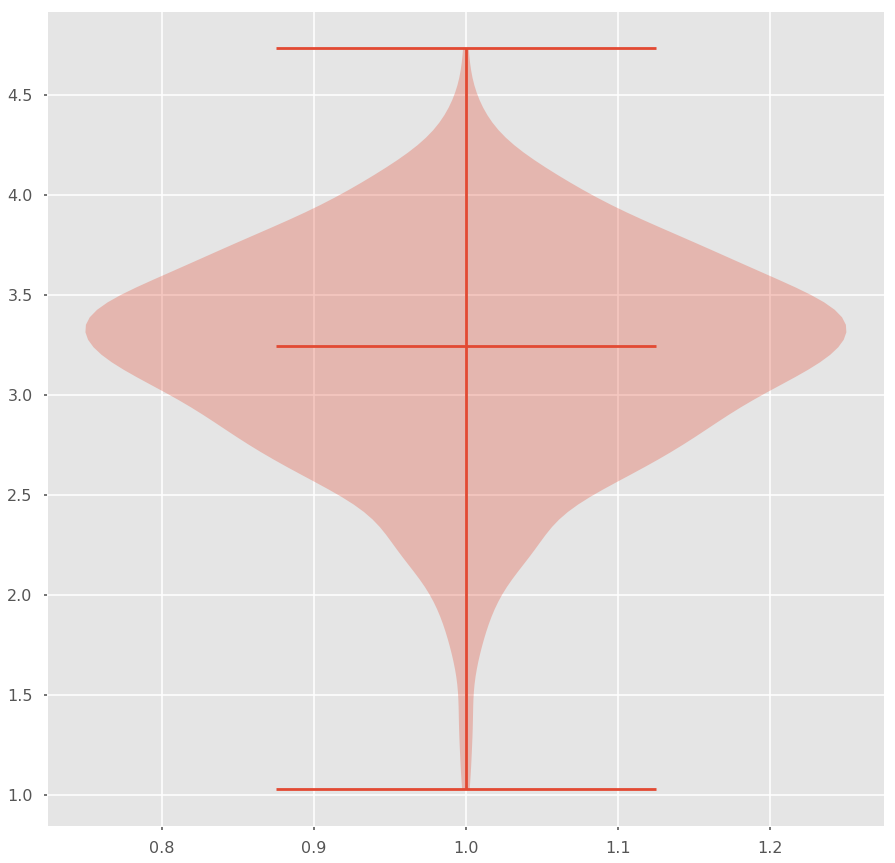

In [113]:
plot_distribution(df.rating)

count    356.000000
mean       3.434667
std        0.467754
min        1.293723
25%        3.129138
50%        3.440879
75%        3.755729
max        4.736726
Name: rating, dtype: float64
skew --  -0.3530612341468383
kurtosis -- 0.8041998841309135


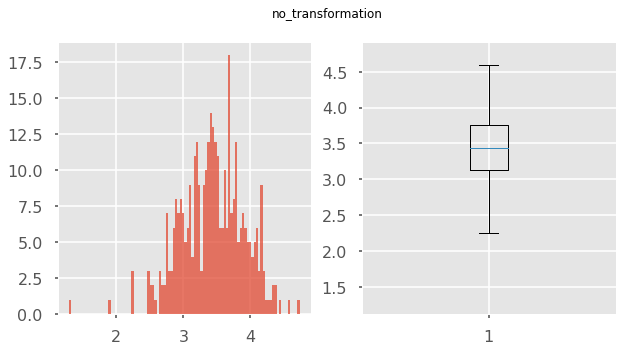

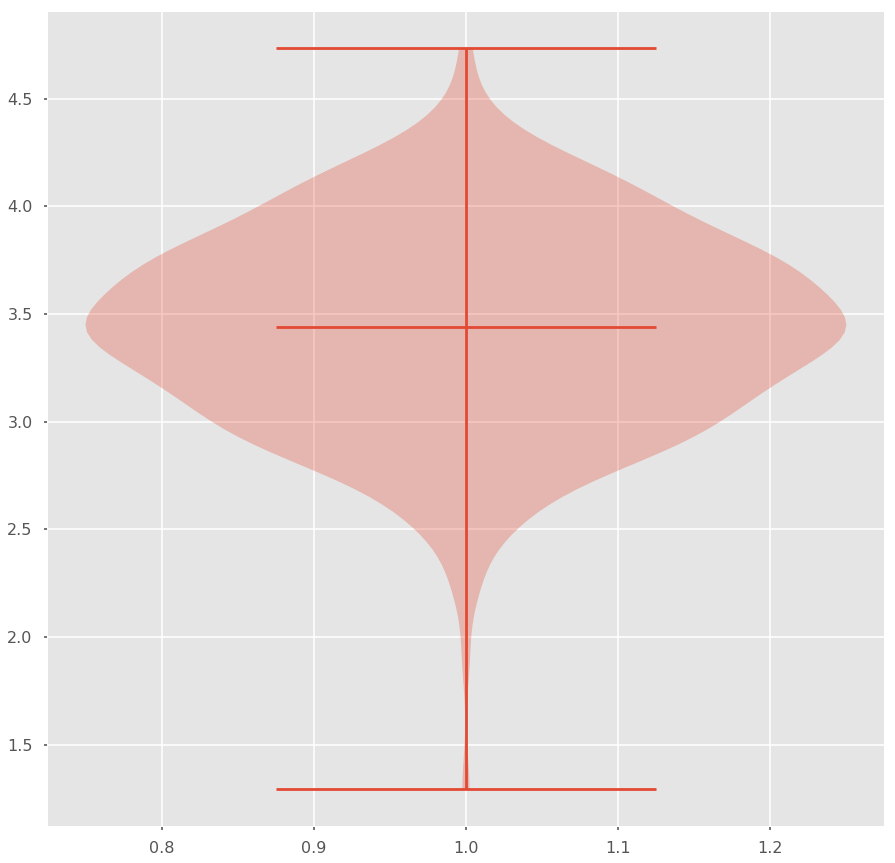

In [104]:
plot_distribution(df[df.like_or_not == 1.0].rating)

count    638.000000
mean       3.075031
std        0.535498
min        1.029219
25%        2.737999
50%        3.141243
75%        3.443571
max        4.452377
Name: rating, dtype: float64
skew --  -0.5993646258780031
kurtosis -- 0.6018571977933505


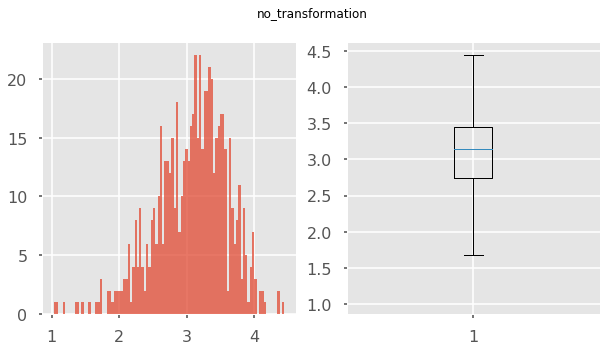

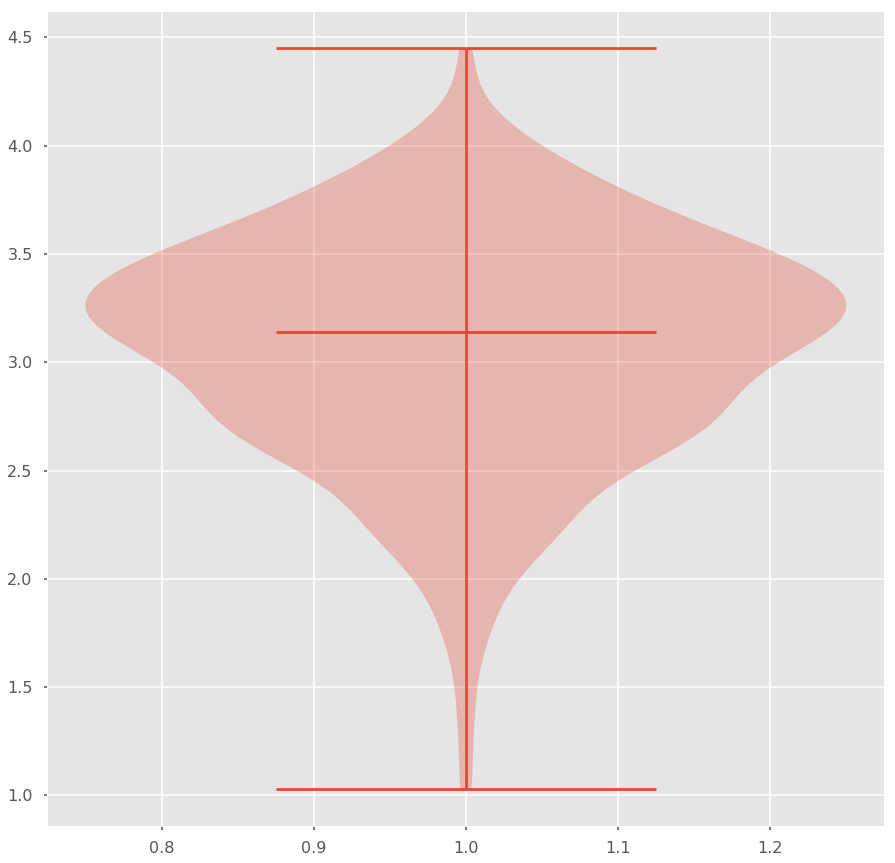

In [105]:
plot_distribution(df[df.like_or_not == 0.0].rating)

## Clearly two seperate populations

The likes: Notice how shifted to the right ( more attractive ) .

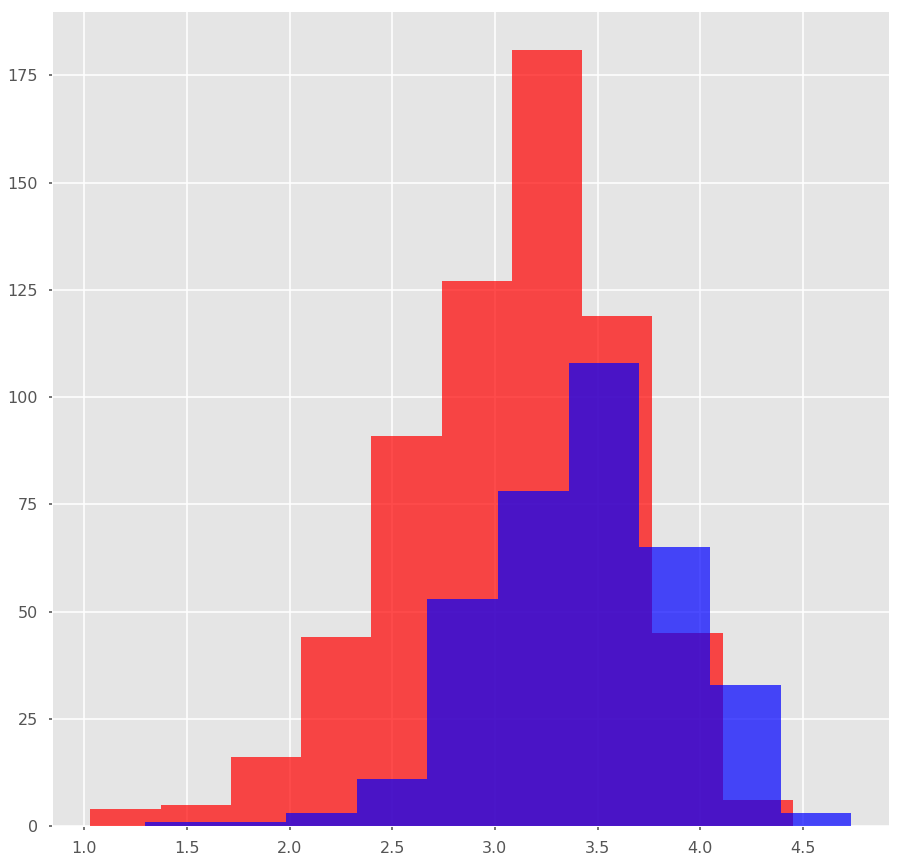

In [110]:
df[df.like_or_not == 0.0].rating.hist(alpha=0.7,bins=10, color='red')
df[df.like_or_not == 1.0].rating.hist(alpha=0.7,bins=10, color='blue')

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a260a32e8>],
 'cbars': <matplotlib.collections.LineCollection at 0x1a260a3860>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a260a3a90>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1a260a3c50>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a260a3320>}

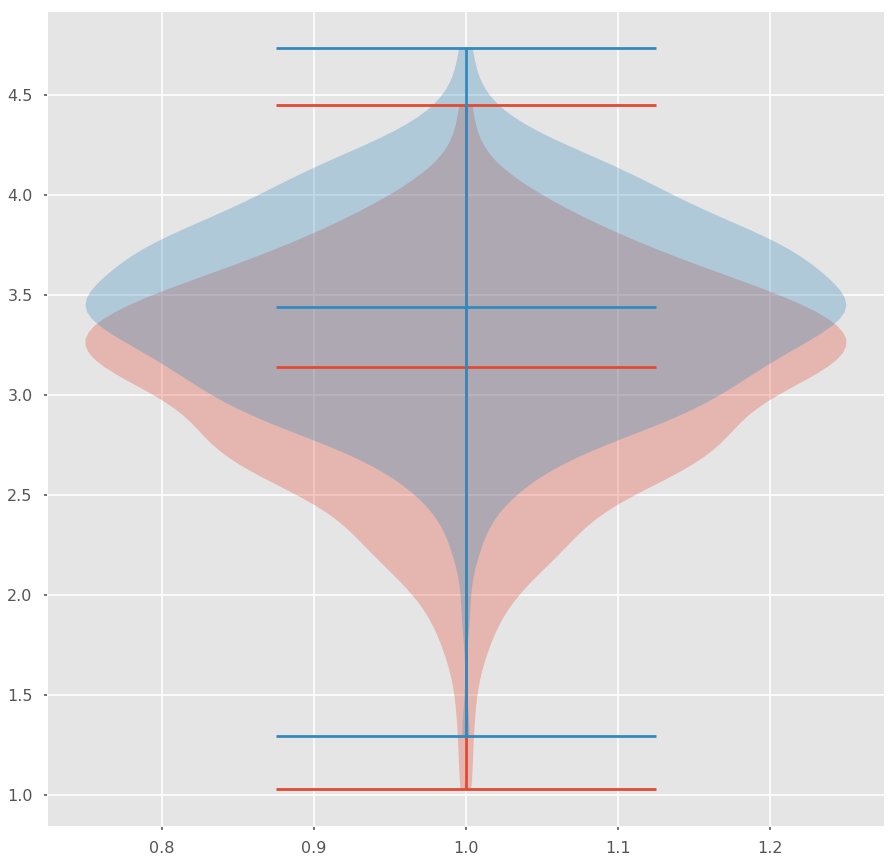

In [111]:
plt.violinplot(
       df[df.like_or_not == 0.0].rating,
       showmeans=False,
       showmedians=True
    )

plt.violinplot(
       df[df.like_or_not == 1.0].rating,
       showmeans=False,
       showmedians=True
    )
